In [2]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
#from deep_translator import GoogleTranslator
#normalization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer
import nltk

In [ ]:
pip install deep-translator

In [ ]:
from deep_translator import GoogleTranslator

In [ ]:
BASE_PATH = '../input/coco-2017-dataset/coco2017'

# Translate Engish Captons into Arabic

In [ ]:
# Load captions data
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

# Extract image-caption pairs
img_cap_pairs = []
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

# Create DataFrame
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(lambda x: f'{BASE_PATH}/train2017/{x}')

# Display the number of captions
print(f"Total number of captions: {len(captions)}")

# Sample 50,000 captions (if there are at least 50,000)
if len(captions) >= 12000:
    captions = captions.sample(12000).reset_index(drop=True)
else:
    print("Warning: There are fewer than 50,000 captions available.")
    captions = captions.reset_index(drop=True)

# Translate captions to Arabic
def translate_caption(text):
    translated_text = GoogleTranslator(source='en', target='ar').translate(text)
    return translated_text

captions['caption_arabic'] = captions['caption'].apply(translate_caption)

# Display the first few rows
print(captions.head())

In [ ]:
# Save to CSV file
captions.to_csv('captions.csv', index=False) 

# ** Actual Work **

In [3]:
captions=pd.read_csv("/kaggle/input/captions-csv/captions.csv")
captions

image  \
0      /content/coco2017/train2017/000000175642.jpg   
1      /content/coco2017/train2017/000000248001.jpg   
2      /content/coco2017/train2017/000000311988.jpg   
3      /content/coco2017/train2017/000000059313.jpg   
4      /content/coco2017/train2017/000000565198.jpg   
...                                             ...   
11995  /content/coco2017/train2017/000000460392.jpg   
11996  /content/coco2017/train2017/000000321389.jpg   
11997  /content/coco2017/train2017/000000011258.jpg   
11998  /content/coco2017/train2017/000000392015.jpg   
11999  /content/coco2017/train2017/000000224081.jpg   

                                                 caption  \
0       A picture of a young woman surfing on the ocean.   
1          A small dog curled up in bed with it's owner.   
2      Dining table set with dishes and vases of flow...   
3      The man is jumping out of the water while kite...   
4      A little girl holding a blow dryer next to her...   
...                                                  ...   
11995                 A woman on skis on the ski slopes    
11996             A group of men play a game of soccer.    
11997      two people standing in front of a motorcycle    
11998       Five giraffes eating hay in a zoo enclosure.   
11999  A toilet sits oddly on a sidewalk in a residen...   

                                          caption_arabic  
0               صورة لامرأة شابة تركب الأمواج في المحيط.  
1                      كلب صغير متكئ في السرير مع صاحبه.  
2            طقم طاولة طعام مع أطباق ومزهريات من الزهور.  
3      الرجل يقفز من الماء أثناء ممارسة رياضة ركوب ال...  
4                  فتاة صغيرة تحمل مجفف شعر بجانب رأسها.  
...                                                  ...  
11995                     امرأة تتزلج على منحدرات التزلج  
11996            مجموعة من الرجال يلعبون لعبة كرة القدم.  
11997                       شخصان يقفان أمام دراجة نارية  
11998       خمس زرافات تأكل القش في حظيرة حديقة الحيوان.  
11999    يوجد مرحاض بشكل غريب على الرصيف في منطقة سكنية.  

[12000 rows x 3 columns]

In [4]:
captions = captions[['image', 'caption_arabic']]

In [5]:
# Update the 'image' column
captions['image'] = captions['image'].str.replace('/content/', '../input/coco-2017-dataset/')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


تقف مجموعة من الأفيال خارجًا بالقرب من الأشجار.



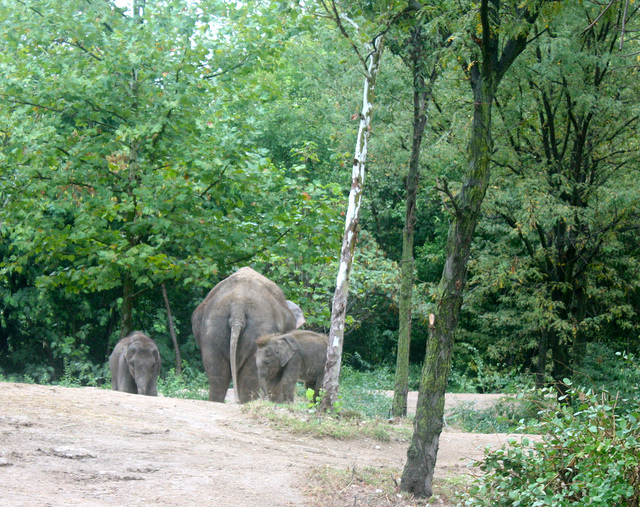

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption_arabic)
print()
im = Image.open(random_row.image)
im

# Pre-Processing

## Normalize Arabic words

In [7]:
#convert ”إ أ آ” to ”ا”
nltk.download('punkt')

def normalize_arabic(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove diacritics
    # (NLTK does not have built-in functionality for diacritics removal,
    # you may need to use another library or implement it yourself)
    
    # Normalize the words
    stemmer = ISRIStemmer()
    normalized_words = [stemmer.stem(word) for word in tokens]
    
    # Join the normalized words back into a single string
    normalized_text = ' '.join(normalized_words)
    
    return normalized_text

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Remove diacritics

In [8]:
pip install pyarabic

Note: you may need to restart the kernel to use updated packages.


In [9]:
#ازاله علامات التشكيل
import pyarabic.araby as araby

# Function to remove Arabic diacritics using pyarabic library
def remove_diacritics(text):
    # Use the strip_diacritics function from the pyarabic library
    text_without_diacritics = araby.strip_diacritics(text)
    
    return text_without_diacritics

## Remove punctuation

In [10]:
#, () / ;
def remove_punctuation(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

## Remove English words 

In [11]:
def remove_english_words(text):
    # Define a regex pattern to match English words
    english_pattern = re.compile(r'\b[a-zA-Z]+\b')

    # Replace English words with an empty string
    cleaned_text = re.sub(english_pattern, '', text)

    return cleaned_text

## Add [start] and [end]

In [12]:
def preprocess(text):

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Trim leading and trailing whitespace
    text = text.strip()
    
    # Add start and end tokens
    text = '[end] ' + text + ' [start]'
    
    return text

### Text before preprocssing

In [13]:
captions.head()

image  \
0  ../input/coco-2017-dataset/coco2017/train2017/...   
1  ../input/coco-2017-dataset/coco2017/train2017/...   
2  ../input/coco-2017-dataset/coco2017/train2017/...   
3  ../input/coco-2017-dataset/coco2017/train2017/...   
4  ../input/coco-2017-dataset/coco2017/train2017/...   

                                      caption_arabic  
0           صورة لامرأة شابة تركب الأمواج في المحيط.  
1                  كلب صغير متكئ في السرير مع صاحبه.  
2        طقم طاولة طعام مع أطباق ومزهريات من الزهور.  
3  الرجل يقفز من الماء أثناء ممارسة رياضة ركوب ال...  
4              فتاة صغيرة تحمل مجفف شعر بجانب رأسها.

In [14]:
df1=captions.copy()

### Example of how the functions change the captions

#### *remove diacritics example*

In [15]:
ex=df1['caption_arabic'].iloc[26:27]
print(ex)

26    طفل يطعم طائرًا داخل حظيرة يتم صقلها على فرع ف...
Name: caption_arabic, dtype: object


In [16]:
# as shown the ' where remoed in طائرًا
first_row_diac = ex.apply(remove_diacritics)
print(first_row_diac)

26    طفل يطعم طائرا داخل حظيرة يتم صقلها على فرع في...
Name: caption_arabic, dtype: object


#### *remove punctuations example*

In [17]:
ex=df1['caption_arabic'].iloc[6:7]
print(ex)

6    عدة أشخاص في غرفة المعيشة مع كلب.
Name: caption_arabic, dtype: object


In [18]:
#as shown the dots where removed
first_row_punc = ex.apply(remove_punctuation)
print(first_row_punc)

6    عدة أشخاص في غرفة المعيشة مع كلب
Name: caption_arabic, dtype: object


#### *adding start and end*

In [19]:
# Apply normalize_arabic to the first row of the 'caption_arabic' column
first_row_pre = ex.apply(preprocess)

# Print the result
print(first_row_pre)

6    [end] عدة أشخاص في غرفة المعيشة مع كلب. [start]
Name: caption_arabic, dtype: object


#### *remove the english words*

In [20]:
ex=df1['caption_arabic'].iloc[89:90]
print(ex)

89    رجل يلعب لعبة فيديو Wii ويشاهدها الناس.
Name: caption_arabic, dtype: object


In [21]:
#as shown the word Wii is removed
remove_english_wordss = ex.apply(remove_english_words)

# Print the result
print(remove_english_wordss)

89    رجل يلعب لعبة فيديو  ويشاهدها الناس.
Name: caption_arabic, dtype: object


### Applying all the processes 

In [22]:
# Apply the preprocessing functions to the 'caption_arabic' column
captions['caption_arabic'] = captions['caption_arabic'].apply(remove_diacritics)
captions['caption_arabic'] = captions['caption_arabic'].apply(remove_punctuation)
captions['caption_arabic'] = captions['caption_arabic'].apply(remove_english_words)
captions['caption_arabic'] = captions['caption_arabic'].apply(preprocess)
# Display the modified DataFrame
captions.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

image  \
0  ../input/coco-2017-dataset/coco2017/train2017/...   
1  ../input/coco-2017-dataset/coco2017/train2017/...   
2  ../input/coco-2017-dataset/coco2017/train2017/...   
3  ../input/coco-2017-dataset/coco2017/train2017/...   
4  ../input/coco-2017-dataset/coco2017/train2017/...   

                                      caption_arabic  
0  [end] صورة لامرأة شابة تركب الأمواج في المحيط ...  
1     [end] كلب صغير متكئ في السرير مع صاحبه [start]  
2  [end] طقم طاولة طعام مع أطباق ومزهريات من الزه...  
3  [end] الرجل يقفز من الماء أثناء ممارسة رياضة ر...  
4  [end] فتاة صغيرة تحمل مجفف شعر بجانب رأسها [st...

## Tokenizing the words

In [23]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

In [24]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption_arabic'])

In [25]:
tokenizer.vocabulary_size()

9596

In [26]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [27]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [28]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption_arabic']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [29]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(9587, 9587, 2413, 2413)

In [30]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [33]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [34]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [35]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [36]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [37]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [38]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87924736/87910968 [==============================] - 5s 0us/step


In [39]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [40]:
history = caption_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/50
150/150 [==============================] - 120s 690ms/step - loss: 6.8375 - acc: 0.1140 - val_loss: 6.4753 - val_acc: 0.1520
Epoch 2/50
150/150 [==============================] - 75s 489ms/step - loss: 6.0618 - acc: 0.1629 - val_loss: 5.8518 - val_acc: 0.1822
Epoch 3/50
150/150 [==============================] - 75s 489ms/step - loss: 5.3352 - acc: 0.1998 - val_loss: 5.4316 - val_acc: 0.2168
Epoch 4/50
150/150 [==============================] - 75s 487ms/step - loss: 4.8400 - acc: 0.2387 - val_loss: 5.1856 - val_acc: 0.2394
Epoch 5/50
150/150 [==============================] - 75s 486ms/step - loss: 4.4350 - acc: 0.2714 - val_loss: 5.0754 - val_acc: 0.2545
Epoch 6/50
150/150 [==============================] - 75s 487ms/step - loss: 4.1121 - acc: 0.2927 - val_loss: 5.0151 - val_acc: 0.2655
Epoch 7/50
150/150 [==============================] - 75s 488ms/step - loss: 3.8407 - acc: 0.3124 - val_loss: 5.0344 - val_acc: 0.2685
Epoch 8/50
150/150 [==============================] - 

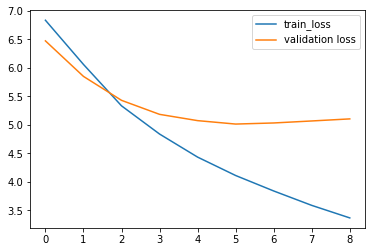

In [41]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [42]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[end]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[start]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[end] ', '')
    return y_inp

Predicted Caption: رجل يحمل جهاز كمبيوتر محمول على طاولة



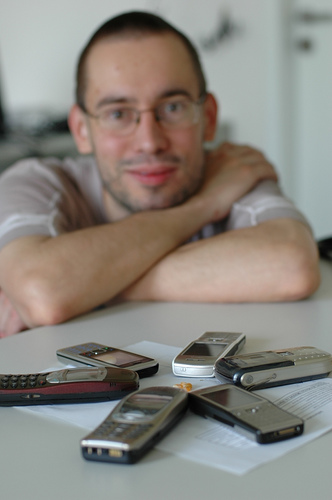

In [43]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: قطيع من الأغنام يرعى في حقل عشبي



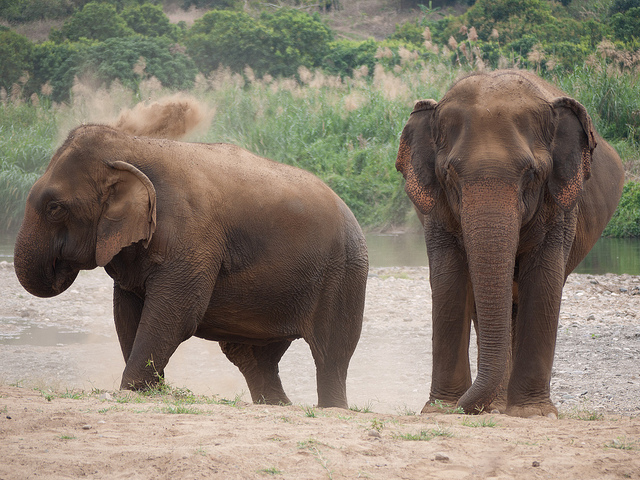

In [44]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: رجل يحمل ملعقة في وعاء من الطعام



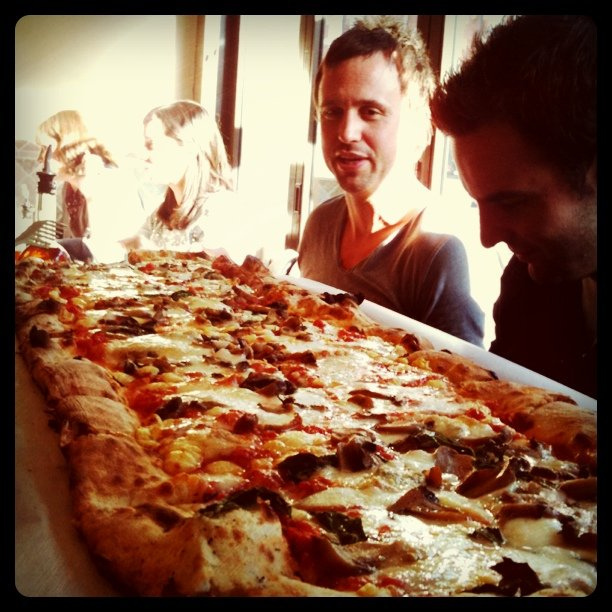

In [45]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: حمام مع مرحاض أبيض مع مرحاض أبيض



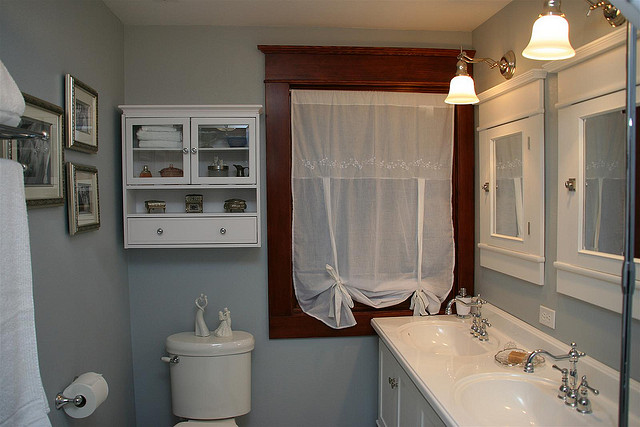

In [51]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: قارب أبيض على الشاطئ مع طائرة ورقية



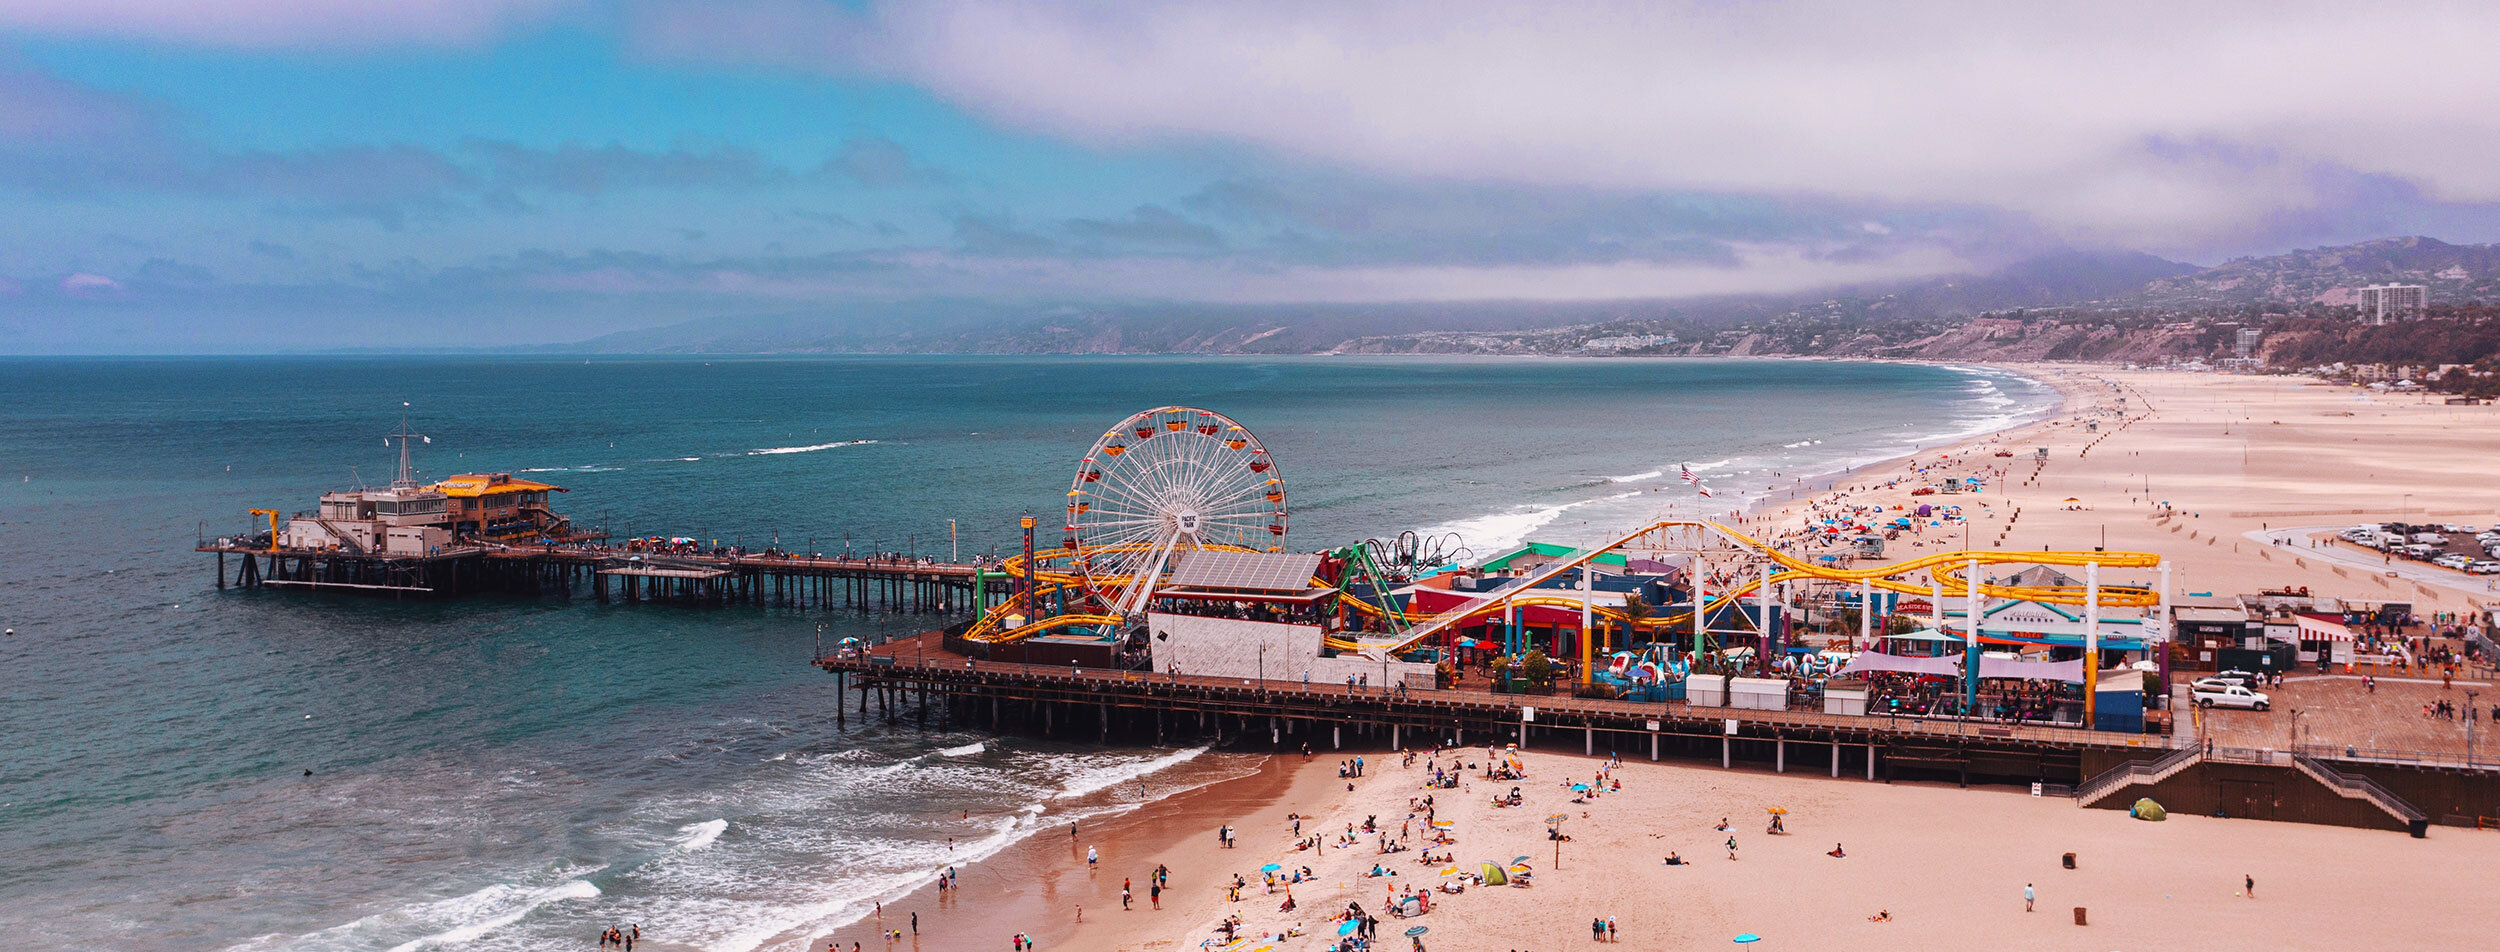

In [46]:
img_url = "https://images.squarespace-cdn.com/content/v1/5e0e65adcd39ed279a0402fd/1627422658456-7QKPXTNQ34W2OMBTESCJ/1.jpg?format=2500w"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [47]:
caption_model.save_weights('Model1.h5')